In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import sqlite3
import matplotlib.pyplot as plt

In [2]:
from sklearn import neighbors

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
# EXPERIMENT_DIR = '/home/ubuntu/experiments/dwm-test'
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test'

In [5]:
EXTRACTED_FEATURES_DB_NAME = "{}/extracted-features/extracted-features.sqlite".format(EXPERIMENT_DIR)
MAPPING_FILE_NAME = "{}/recalibrated-percolator-output/percolator-idx-mapping.csv".format(EXPERIMENT_DIR)


In [6]:
# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result


In [7]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
sequences_df = pd.read_sql_query('select sequence,charge,file_idx,intensity,peak_proportion_intensity,monoisotopic_mass,monoisotopic_mz_centroid,rt_apex,scan_apex,run_name,batch,human,number_of_runs_extracted from features where (rt_apex is not null) and (scan_apex is not null)', db_conn)
db_conn.close()


In [8]:
sequences_df['log_intensity'] = np.log2(sequences_df.intensity)
sequences_df['log_intensity_peak_proportion'] = np.log2(sequences_df.peak_proportion_intensity)

In [9]:
len(sequences_df)

230714

In [10]:
# find the experiment-wide means and std devs for m/z, CCS, RT
experiment_means_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    # intensity
    experiment_intensity_mean = np.mean(group_df.log_intensity)
    experiment_intensity_std_dev = np.std(group_df.log_intensity)

    experiment_intensity_mean_peak_proportion = np.mean(group_df.log_intensity_peak_proportion)
    experiment_intensity_std_dev_peak_proportion = np.std(group_df.log_intensity_peak_proportion)
    # m/z
    experiment_mz_mean = np.mean(group_df.monoisotopic_mz_centroid)
    experiment_mz_std_dev = np.std(group_df.monoisotopic_mz_centroid)
    # rt
    experiment_rt_mean = np.mean(group_df.rt_apex)
    experiment_rt_std_dev = np.std(group_df.rt_apex)
    # scan
    experiment_scan_mean = np.mean(group_df.scan_apex)
    experiment_scan_std_dev = np.std(group_df.scan_apex)
    # sequence and charge
    sequence = group_name[0]
    charge = group_name[1]
    experiment_means_l.append((sequence,charge,experiment_intensity_mean,experiment_intensity_std_dev,experiment_intensity_mean_peak_proportion,experiment_intensity_std_dev_peak_proportion,experiment_mz_mean,experiment_mz_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev))

experiment_means_df = pd.DataFrame(experiment_means_l, columns=['sequence','charge','experiment_intensity_mean','experiment_intensity_std_dev','experiment_intensity_mean_peak_proportion','experiment_intensity_std_dev_peak_proportion','experiment_mz_mean','experiment_mz_std_dev','experiment_rt_mean','experiment_rt_std_dev','experiment_scan_mean','experiment_scan_std_dev'])


In [11]:
sequences_df = pd.merge(sequences_df, experiment_means_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])


#### Note that from now on we work with intensity and intensity delta in log2 space. The median is the median of log2(intensity).

In [12]:
sequences_df['delta_intensity'] = sequences_df.log_intensity - sequences_df.experiment_intensity_mean
sequences_df['delta_intensity_peak_proportion'] = sequences_df.log_intensity_peak_proportion - sequences_df.experiment_intensity_mean_peak_proportion


In [13]:
run_name = '190719_Hela_Ecoli_1to1_01'
file_idx = file_idx_for_run(run_name)

In [14]:
minimum_number_of_runs_for_training_set = 5

In [15]:
sequences_selected_run_df = sequences_df[sequences_df.file_idx == file_idx].copy()
training_set_selected_run_df = sequences_selected_run_df[(sequences_selected_run_df.human == True) & (sequences_selected_run_df.number_of_runs_extracted >= minimum_number_of_runs_for_training_set)]


In [16]:
len(training_set_selected_run_df)

18700

#### use a kNN model to predict the effect on intensity of m/z, CCS, and RT

In [17]:
from sklearn import preprocessing

In [18]:
training_attributes = ['monoisotopic_mz_centroid','rt_apex','scan_apex']

In [19]:
X_train = training_set_selected_run_df[training_attributes].values
y_train = training_set_selected_run_df[['delta_intensity']].values[:,0]

In [20]:
# scaler_X = preprocessing.StandardScaler().fit(X_train)
# scaler_X = preprocessing.Normalizer().fit(X_train)
scaler_X = preprocessing.RobustScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)

In [21]:
knn = neighbors.KNeighborsRegressor(n_neighbors=80, weights='uniform')
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=80, p=2,
                    weights='uniform')

In [22]:
X = sequences_selected_run_df[training_attributes].values
X_scaled = scaler_X.transform(X)

In [23]:
predicted_delta_intensity = knn.predict(X_scaled)
predicted_delta_intensity

array([0.19561053, 0.13470148, 0.14130597, ..., 0.13422462, 0.12059467,
       0.01085981])

In [24]:
sequences_selected_run_df['predicted_delta_intensity'] = predicted_delta_intensity

In [25]:
mean_delta_l = []
for group_name,group_df in sequences_selected_run_df.groupby(['rt_apex'], as_index=False):
    mean_delta_l.append((group_name, np.mean(group_df.predicted_delta_intensity)))
mean_delta_df = pd.DataFrame(mean_delta_l, columns=['rt_apex','mean_delta_intensity'])

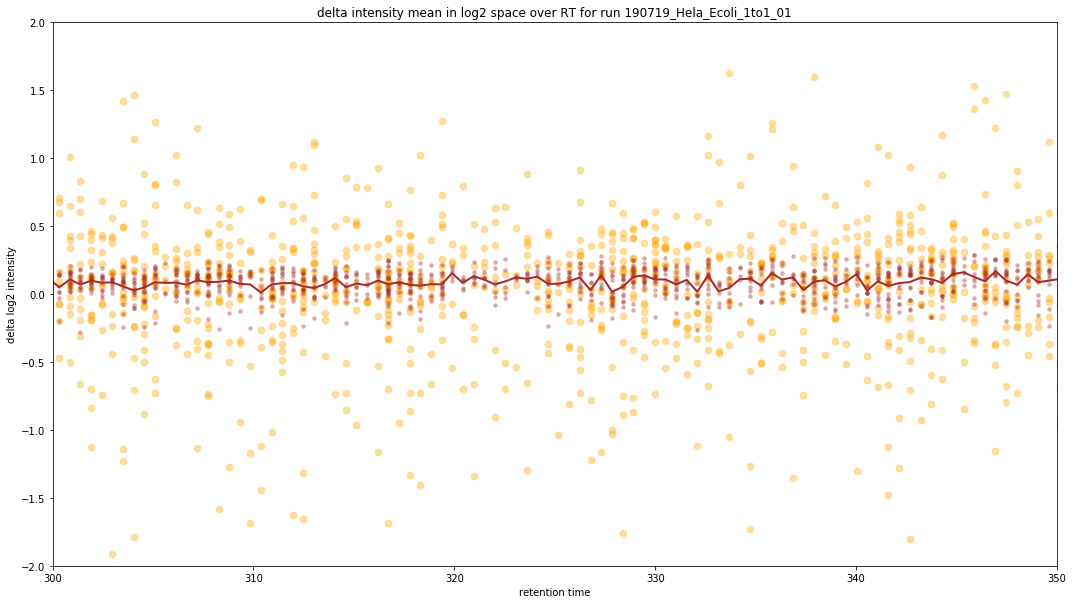

In [26]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(sequences_selected_run_df.rt_apex, sequences_selected_run_df.delta_intensity, marker='o', color='orange', lw=0, s=60, alpha=0.4)
ax.scatter(sequences_selected_run_df.rt_apex, predicted_delta_intensity, marker='o', color='brown', lw=0, s=20, alpha=0.4)
ax.plot(mean_delta_df.rt_apex, mean_delta_df.mean_delta_intensity, marker='', color='brown', linestyle='-', linewidth=2, ms=5)

# plt.legend(loc='best')
plt.ylabel('delta log2 intensity')
plt.xlabel('retention time')
plt.title('delta intensity mean in log2 space over RT for run {}'.format(run_name))
plt.xlim((300,350))
plt.ylim((-2,2))

plt.show()

In [27]:
mean_delta_l = []
for group_name,group_df in sequences_selected_run_df.groupby(['scan_apex'], as_index=False):
    mean_delta_l.append((group_name, np.mean(group_df.predicted_delta_intensity)))
mean_delta_df = pd.DataFrame(mean_delta_l, columns=['scan_apex','mean_delta_intensity'])

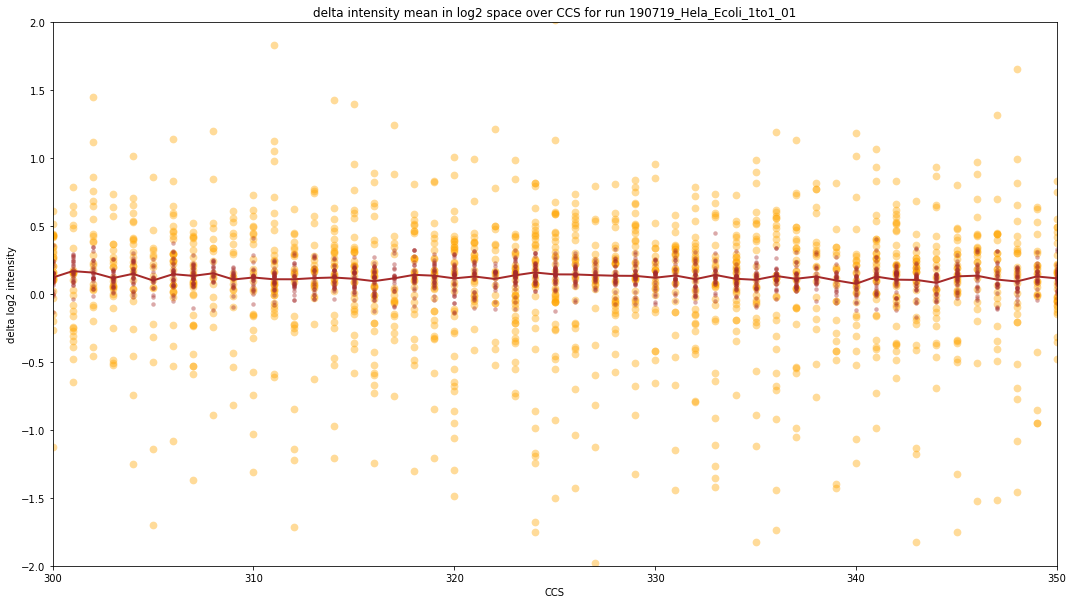

In [28]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(sequences_selected_run_df.scan_apex, sequences_selected_run_df.delta_intensity, marker='o', color='orange', lw=0, s=60, alpha=0.4)
ax.scatter(sequences_selected_run_df.scan_apex, predicted_delta_intensity, marker='o', color='brown', lw=0, s=20, alpha=0.4)
ax.plot(mean_delta_df.scan_apex, mean_delta_df.mean_delta_intensity, marker='', color='brown', linestyle='-', linewidth=2, ms=5)

# plt.legend(loc='best')
plt.ylabel('delta log2 intensity')
plt.xlabel('CCS')
plt.title('delta intensity mean in log2 space over CCS for run {}'.format(run_name))
plt.xlim((300,350))
plt.ylim((-2,2))

plt.show()

In [29]:
mean_delta_l = []
sequences_selected_run_df['mz_truncated'] = sequences_selected_run_df.monoisotopic_mz_centroid.astype(int)
for group_name,group_df in sequences_selected_run_df.groupby(['mz_truncated'], as_index=False):
    mean_delta_l.append((group_name, np.mean(group_df.predicted_delta_intensity)))
mean_delta_df = pd.DataFrame(mean_delta_l, columns=['monoisotopic_mz_centroid','mean_delta_intensity'])

In [30]:
sequences_selected_run_df[['monoisotopic_mz_centroid','mz_truncated']].sample(5)

,monoisotopic_mz_centroid,mz_truncated
201918,735.379120,735
206851,695.981525,695
203280,1073.075696,1073
204985,772.379366,772
201912,1058.974306,1058


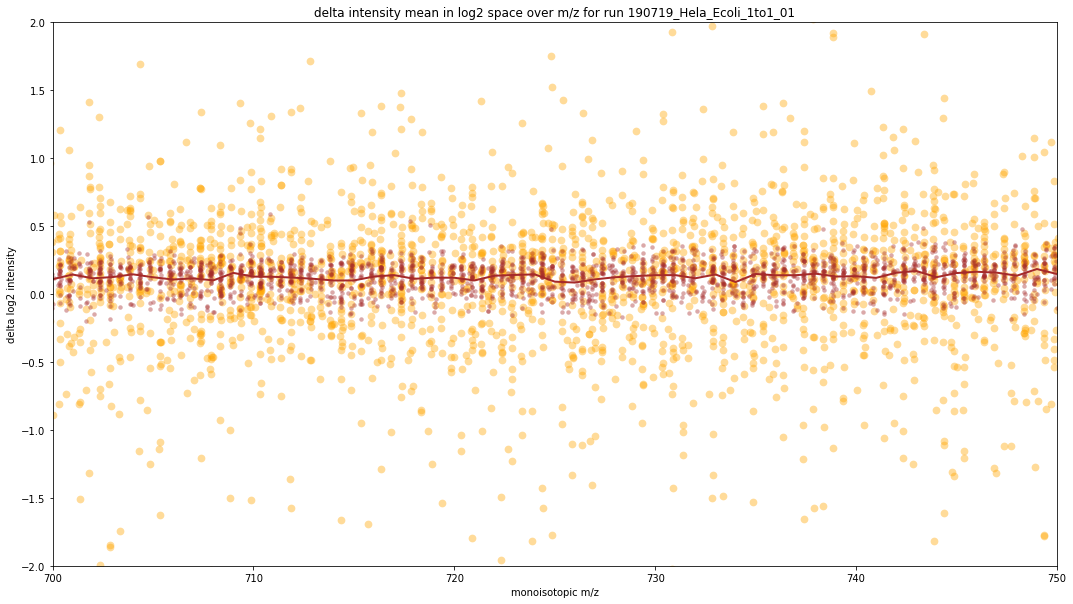

In [31]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(sequences_selected_run_df.monoisotopic_mz_centroid, sequences_selected_run_df.delta_intensity, marker='o', color='orange', lw=0, s=60, alpha=0.4)
ax.scatter(sequences_selected_run_df.monoisotopic_mz_centroid, predicted_delta_intensity, marker='o', color='brown', lw=0, s=20, alpha=0.4)
ax.plot(mean_delta_df.monoisotopic_mz_centroid, mean_delta_df.mean_delta_intensity, marker='', color='brown', linestyle='-', linewidth=2, ms=5)

# plt.legend(loc='best')
plt.ylabel('delta log2 intensity')
plt.xlabel('monoisotopic m/z')
plt.title('delta intensity mean in log2 space over m/z for run {}'.format(run_name))
plt.xlim((700,750))
plt.ylim((-2,2))

plt.show()

In [32]:
# subtract the predicted delta intensity from the intensity to normalise
sequences_selected_run_df['normalised_log_intensity'] = sequences_selected_run_df.log_intensity - predicted_delta_intensity
sequences_selected_run_df['normalised_intensity'] = np.power(2, sequences_selected_run_df.normalised_log_intensity)


In [33]:
run_df_l = []
for group_name,group_df in sequences_df.groupby(['file_idx'], as_index=False):
    # get the training set for this run
    sequences_selected_run_df = sequences_df[sequences_df.file_idx == int(group_name)].copy()
    training_set_selected_run_df = sequences_selected_run_df[(sequences_selected_run_df.human == True) & (sequences_selected_run_df.number_of_runs_extracted >= minimum_number_of_runs_for_training_set)]
    X_train = training_set_selected_run_df[training_attributes].values
    y_train = training_set_selected_run_df[['delta_intensity']].values[:,0]
    # scale the training set input values
    scaler_X = preprocessing.RobustScaler().fit(X_train)
    X_train_scaled = scaler_X.transform(X_train)
    # fit the model
    knn = neighbors.KNeighborsRegressor(n_neighbors=500, weights='uniform')
    _ = knn.fit(X_train_scaled, y_train)
    # scale the input values
    X = sequences_selected_run_df[training_attributes].values
    X_scaled = scaler_X.transform(X)
    # estimate the delta intensity
    predicted_delta_intensity = knn.predict(X_scaled)
    sequences_selected_run_df['predicted_delta_intensity'] = predicted_delta_intensity
    # subtract the predicted delta intensity from the intensity to normalise
    sequences_selected_run_df['normalised_log_intensity'] = sequences_selected_run_df.log_intensity - predicted_delta_intensity
    sequences_selected_run_df['normalised_intensity'] = np.power(2, sequences_selected_run_df.normalised_log_intensity)
    # add it to the list of runs
    run_df_l.append(sequences_selected_run_df)

normalised_sequences_df = pd.concat(run_df_l, axis=0, sort=False)


In [34]:
# for each sequence, find the CV
sequence_cv_l = []
for group_name,group_df in normalised_sequences_df.groupby(['sequence','charge']):
    if len(group_df) == 10:
        intensity_cv = np.std(group_df.normalised_intensity) / np.mean(group_df.normalised_intensity)
        sequence_cv_l.append((group_name[0], group_name[1], intensity_cv))
sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','charge','intensity_cv'])


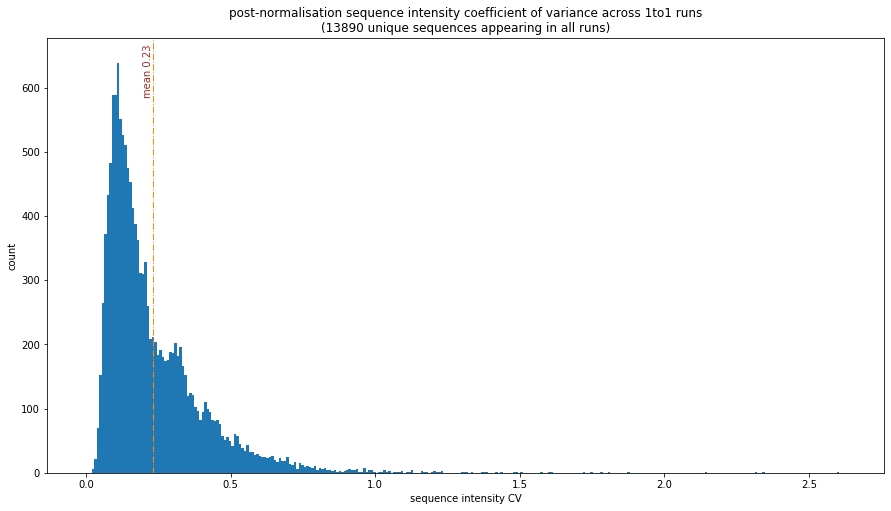

In [35]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
values = sequence_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('post-normalisation sequence intensity coefficient of variance across 1to1 runs\n({} unique sequences appearing in all runs)'.format(len(sequence_cv_df)))

plt.show()